# Week 6 Assignment

Matthew Tillmawitz

## Introduction

For this assignment we will be analysing the Southern Women dataset which tracks the attendance of 18 women at 14 different social events in Natchez, Mississippi in the 1930s. The dataset produces a bipartite network consisting of the women and events as nodes with attendence at an event creating edges between women and event nodes. Using projection we can apply unipartite methods in addition to bipartite specific analysis to get an understanding of the social structure present in the society of this town.

In [294]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from networkx.algorithms import bipartite, community
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform, pdist


In [295]:
G = nx.davis_southern_women_graph()
women = [n for n, d in G.nodes(data=True) if d['bipartite'] == 0]
events = [n for n, d in G.nodes(data=True) if d['bipartite'] == 1]

women = sorted(women)
events = sorted(events)

women_graph = bipartite.projected_graph(G, women)
event_graph = bipartite.projected_graph(G, events)

colors = sns.color_palette("colorblind", 2)

## Initial Bipartite Exploration

Visualizing the full bipartite network is not particularly helpful, as attendence intitially appears to be fairly randomly distributed. Upon further inspection, we can uncover some insights that will guide our analysis. Looking at the women on the left hand side, we can see that there are some nodes with a large number of events attended while others have very few. This indicates there are some individuals highly tapped into the society of this town who attend many events while others are more peripherally involved. Considering the events, there appears to be a more even distribution of attendence numbers with a few events with very high attendence while most have a more moderate level of attendence and a handful have very low attendence. With these initial observations we can proceed to explore the nature of these relationships in greater detail.

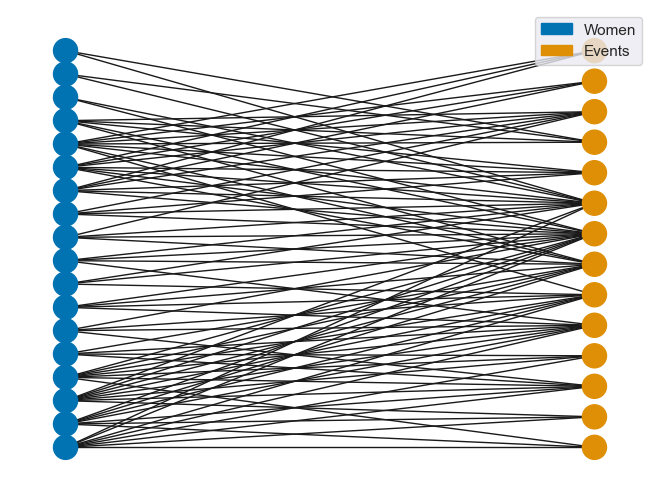

In [296]:
node_colors = [colors[0] if G.nodes[node]['bipartite'] == 0 else colors[1] for node in G.nodes()]
# Maybe pick the event with the most attendees?
pos = nx.bipartite_layout(G)
nx.draw(G, node_color=node_colors, pos=pos)

legend_elements = [
    mpatches.Patch(color=colors[0], label='Women'),
    mpatches.Patch(color=colors[1], label='Events')
]

plt.legend(handles=legend_elements, loc='upper right')
plt.show()

In [297]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

node_data = []
for node in G.nodes():
    node_data.append({
        'node': node,
        'bipartite': G.nodes()[node]['bipartite'],
        'degree_centrality': degree_centrality[node],
        'betweenness_centrality': betweenness_centrality[node],
        'degree': G.degree(node)
    })

df = pd.DataFrame(node_data)

Looking at the attendence distribution of the women, we can see an interesting pattern emerge. There appear to be a cluster of individuals who attend 7 or 8 events, another that attend 4 events, and lastly a few who only attend 2 events. This again indicates the group can be divided into highly, moderately, and peripherally engaged members, but leaves us with some questions. Are the highly connected individuals at the center of different social groups or members of an elite core that more occasionally allows other members in? Looking at the meeting attendence we can begin to get an understanding. The majority of events have low attendence of fewer than 6 women present with a few events consisting of half or more of the population. This means that most events are meetings of smaller groups with a few large events that allow either more peripheral members to attend or combine different highly connected subgroups.

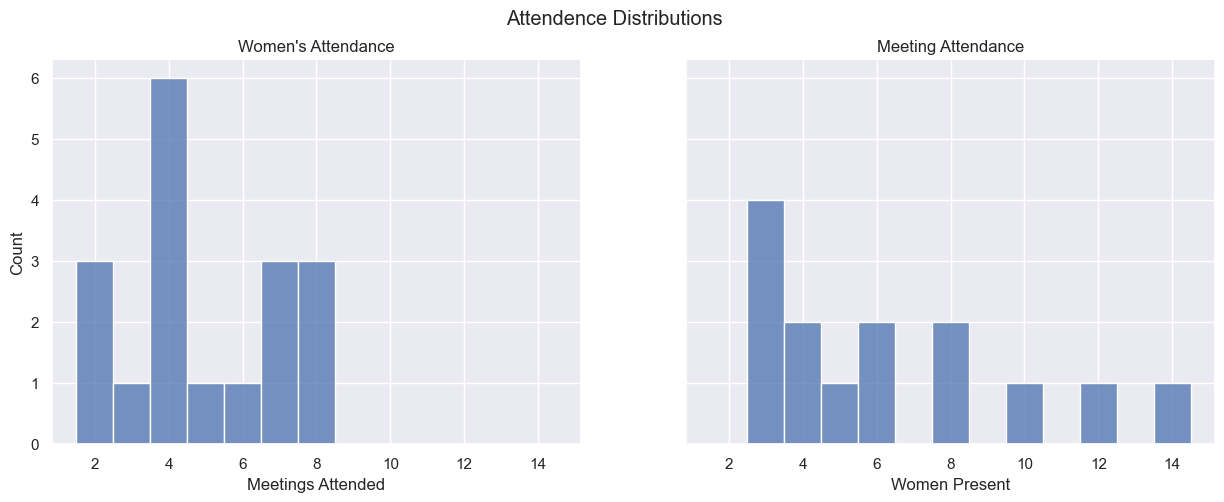

In [298]:
sns.set_theme()

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
fig.suptitle("Attendence Distributions")

sns.histplot(data=df[df['bipartite'] == 0], binwidth=1, discrete=True, x='degree', ax=axes[0])
axes[0].set_title("Women's Attendance")
axes[0].set_xlabel("Meetings Attended")
axes[0].set_ylabel("Count")

sns.histplot(data=df[df['bipartite'] == 1], binwidth=1, discrete=True, x='degree', ax=axes[1])
axes[1].set_title("Meeting Attendance")
axes[1].set_xlabel("Women Present")

plt.show()

## Evaluating Projections

By projecting the bipartite network into two unipartite networks we can begin to get a more defined picture of the social network. Using event attendance to define the edges connecting women, we can create a unipartite network with weighted edges indicating the number of events attended together. Visualizing the graph provides a much clearer picture of the stratification present in the society, with two distinct highly connected groups becoming clear with some peripheral members at the edges.

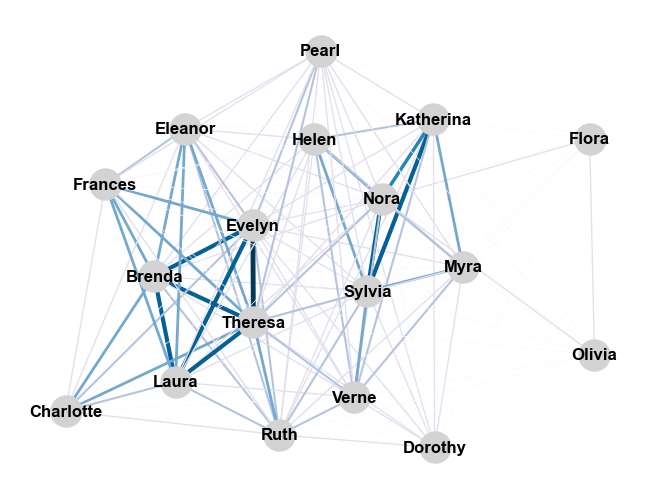

In [299]:
weighted_women_graph = bipartite.weighted_projected_graph(G, women)

labels = {name: name.split()[0] for name in weighted_women_graph.nodes()}

pos = nx.spring_layout(weighted_women_graph, seed=89)
weights = [weighted_women_graph[u][v]['weight'] for u, v in weighted_women_graph.edges()]

nx.draw(weighted_women_graph, pos, 
        labels=labels,
        width=[w * 0.5 for w in weights],
        edge_color=weights,
        edge_cmap=plt.cm.PuBu,
        node_color='lightgray',
        font_color='black', 
        node_size=500,
        font_weight='bold') 
plt.show()

Only showing edges with a weight greater than 2 further clarifies the picture and highlights the tightly-knit nature of the groups. There is a larger highly connected network seemingly defined by Laura, Evelyn, Brenda, and Theresa with some more lightly connected members and a second clear group of Sylvia, Nora, Katherina, and their peripheral members. Some individuals are only tentatively involved in this social scene and become disconnected islands when the connection threshold is raised. This indicates a heirarchical social structure within this community defined by membership in one of the two groups.

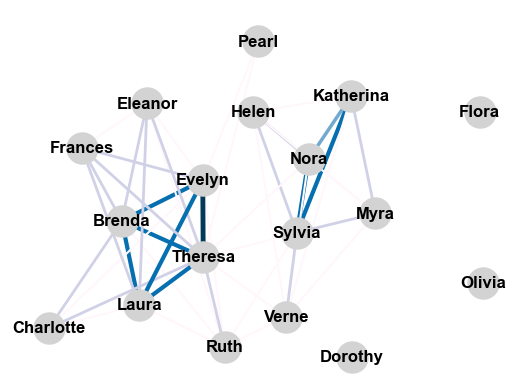

In [300]:
filtered_edges = [(u, v) for u, v, d in weighted_women_graph.edges(data=True) if d['weight'] > 2]
weights = [weighted_women_graph[u][v]['weight'] for u, v in filtered_edges]

# Draw nodes and labels for all nodes, but only filtered edges
pos = nx.spring_layout(weighted_women_graph, seed=89)
labels = {name: name.split()[0] for name in weighted_women_graph.nodes()}

nx.draw_networkx_nodes(weighted_women_graph, pos, node_color='lightgray', node_size=500)
nx.draw_networkx_labels(weighted_women_graph, pos, labels=labels, font_color='black', font_weight='bold')
nx.draw_networkx_edges(weighted_women_graph, pos,
                       edgelist=filtered_edges,  # Only draw filtered edges
                       width=[w * 0.5 for w in weights],
                       edge_color=weights,
                       edge_cmap=plt.cm.PuBu)
plt.axis('off')
plt.show()

Taking a different perspective and creating a projection with shared attendance at an event creating edges muddies the picture created by the previous projection a bit. The events appear to have a high level of connectedness, indicating that the two groups we defined previously might have more intermixing than we thought. We can clarify the picture once again by raising the threshold for edges when visualizing the graph.

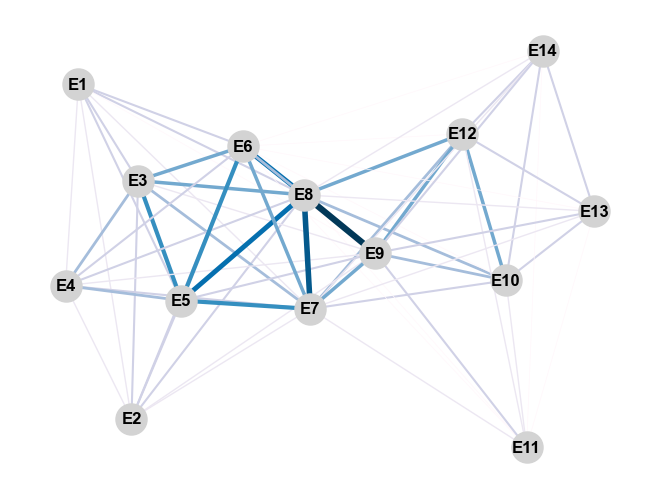

In [301]:
weighted_events_graph = bipartite.weighted_projected_graph(G, events)

pos = nx.spring_layout(weighted_events_graph, seed=67)
weights = [weighted_events_graph[u][v]['weight'] for u, v in weighted_events_graph.edges()]

nx.draw(weighted_events_graph, pos,
        with_labels=True,
        width=[w * 0.5 for w in weights],
        edge_color=weights,
        edge_cmap=plt.cm.PuBu,
        node_color='lightgray',
        font_color='black', 
        node_size=500,
        font_weight='bold')
plt.show()

We can now see a more distinct division in event attendence bridged by events E8 and E9. This backs up our previous conclusions about the distinct groups and provides further evidence that the women in these groups likely attend the same events together given the strong connections between core nodes.

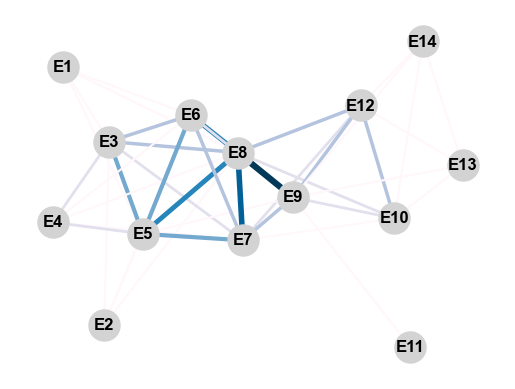

In [302]:
filtered_edges = [(u, v) for u, v, d in weighted_events_graph.edges(data=True) if d['weight'] > 2]
weights = [weighted_events_graph[u][v]['weight'] for u, v in filtered_edges]

# Draw nodes and labels for all nodes, but only filtered edges
pos = nx.spring_layout(weighted_events_graph, seed=67)
labels = {name: name.split()[0] for name in weighted_events_graph.nodes()}

nx.draw_networkx_nodes(weighted_events_graph, pos, node_color='lightgray', node_size=500)
nx.draw_networkx_labels(weighted_events_graph, pos, labels=labels, font_color='black', font_weight='bold')
nx.draw_networkx_edges(weighted_events_graph, pos,
                       edgelist=filtered_edges,  # Only draw filtered edges
                       width=[w * 0.5 for w in weights],
                       edge_color=weights,
                       edge_cmap=plt.cm.PuBu)
plt.axis('off')
plt.show()

## Statistical Analysis of Relationships

More in depth numeric analysis of the network can help us to further define the nature of the relationships we have observed. The degree centrality of the women in the original bipartite graph tells us which women are attending the most events. At the top of the list we see the women that define the two clusters we have identified, indicating the groups are driving much of the social scene in this community. Given what we have observed in previous sections, we can conclude the members of the groups form core social circles that frequently meet together, less frequently attend larger events that include peripheral members, and even less frequent events that span the community.

In [303]:
df.loc[(df['bipartite'] == 0), ['node', 'degree_centrality']].sort_values(by='degree_centrality', ascending=False)

,node,degree_centrality
0,Evelyn Jefferson,0.258065
2,Theresa Anderson,0.258065
13,Nora Fayette,0.258065
1,Laura Mandeville,0.225806
3,Brenda Rogers,0.225806
12,Sylvia Avondale,0.225806
11,Katherina Rogers,0.193548
14,Helen Lloyd,0.161290
10,Myra Liddel,0.129032
9,Verne Sanderson,0.129032


The low betweeness centrality of the women in the bipartite graph further highlights the high degree of segregation between the groups identified. With such low betweeness values, the women rarely cross groups to socialize but when they do it appears to be through the top 3 or 4 individuals. These top individuals in betweeness are also some of the most connected in terms of degree centrality and were previously identified as members of the core observed groups. It seems that these individuals have some organizing role, both defining the groups and acting as bridges between them.

In [304]:
df.loc[(df['bipartite'] == 0), ['node', 'betweenness_centrality']].sort_values(by='betweenness_centrality', ascending=False)

,node,betweenness_centrality
13,Nora Fayette,0.108581
0,Evelyn Jefferson,0.092431
2,Theresa Anderson,0.083827
12,Sylvia Avondale,0.068625
1,Laura Mandeville,0.049149
3,Brenda Rogers,0.047358
11,Katherina Rogers,0.045326
14,Helen Lloyd,0.040564
8,Ruth DeSand,0.016061
10,Myra Liddel,0.015641


The degree centrality of the different events does not tell us much we have not already observed, but does reinforce our previous observations. There are a few large events that involve most or all of the community, with most events consisting of smaller groups.

In [305]:
df.loc[(df['bipartite'] == 1), ['node', 'degree_centrality']].sort_values(by='degree_centrality', ascending=False)

,node,degree_centrality
25,E8,0.451613
26,E9,0.387097
24,E7,0.322581
22,E5,0.258065
23,E6,0.258065
20,E3,0.193548
29,E12,0.193548
27,E10,0.161290
21,E4,0.129032
28,E11,0.129032


Similarly the betweeness centrality largely tells us things we already know, with the most attended events acting as bridges between the community. Of interest is E11, which exhibits a larger than usual gap in terms of rank between the two measures. The lower degree centrality but higher betweeness centrality indicates this was an event attended by relatively few women in the community who were members of the different social circles.

In [306]:
df.loc[(df['bipartite'] == 1), ['node', 'betweenness_centrality']].sort_values(by='betweenness_centrality', ascending=False)

,node,betweenness_centrality
25,E8,0.237003
26,E9,0.219209
24,E7,0.125881
23,E6,0.063199
22,E5,0.036641
28,E11,0.019116
20,E3,0.017715
29,E12,0.017588
27,E10,0.011122
21,E4,0.007487


# Defining the Communities

By using the Jaccard distance we can effectively define the social circles we have identified with distinct boundaries. The Jaccard distance measures the simmilarity in event attendence between two women, with a lower distance indicating the women attended many of the same events together. Using a cutoff of 0.6 for the distance ensures we create communities with at least a minimal degree of overlap, and produces a result we would expect given our previous analysis.

In [307]:
n_women = len(women)
n_events = len(events)
attendance = np.zeros((n_women, n_events), dtype=int)

for i, woman in enumerate(women):
    for j, event in enumerate(events):
        if G.has_edge(woman, event):
            attendance[i][j] = 1

# Build binary attendance matrix for women
n_women = len(women)
n_events = len(events)
attendance_matrix = np.array(attendance)

jaccard_distances = pdist(attendance_matrix, metric='jaccard')

# Hierarchical clustering using average linkage
linkage_matrix = linkage(jaccard_distances, method='average')

# Cut dendrogram to get communities
clusters = fcluster(linkage_matrix, t=0.6, criterion='distance')

print(f"  Communities detected: {len(set(clusters))}")
for cluster_id in sorted(set(clusters)):
    members = [women[i] for i in range(n_women) if clusters[i] == cluster_id]
    print(f"    Community {cluster_id}: {sorted(members)}")

  Communities detected: 4
    Community 1: ['Brenda Rogers', 'Charlotte McDowd', 'Eleanor Nye', 'Evelyn Jefferson', 'Frances Anderson', 'Laura Mandeville', 'Theresa Anderson']
    Community 2: ['Flora Price', 'Olivia Carleton']
    Community 3: ['Helen Lloyd', 'Katherina Rogers', 'Myra Liddel', 'Nora Fayette', 'Sylvia Avondale']
    Community 4: ['Dorothy Murchison', 'Pearl Oglethorpe', 'Ruth DeSand', 'Verne Sanderson']


Four communities are identified when divided in this manner, which match the groups we previously identified. The full projection of the women's relationships has been reproduced below for reference. Aside from the two core groups we identified visually, there is another group of more peripherally involved women as well as a community representing the two women who attended only a couple events. We could likely further divide or aggregate the groups, but this division provides the most intuitive interpretation of the groups.

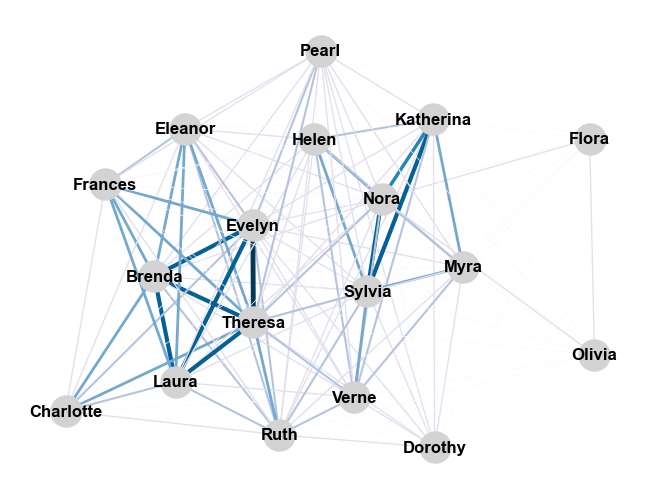

In [308]:
weighted_women_graph = bipartite.weighted_projected_graph(G, women)

labels = {name: name.split()[0] for name in weighted_women_graph.nodes()}

pos = nx.spring_layout(weighted_women_graph, seed=89)
weights = [weighted_women_graph[u][v]['weight'] for u, v in weighted_women_graph.edges()]

nx.draw(weighted_women_graph, pos, 
        labels=labels,
        width=[w * 0.5 for w in weights],
        edge_color=weights,
        edge_cmap=plt.cm.PuBu,
        node_color='lightgray',
        font_color='black', 
        node_size=500,
        font_weight='bold') 
plt.show()

# Conclusions

Our analysis has created a detailed picture of the social setting in this community. We have identified a highly influential core group of women who drive the social scene of the community, with the rest of the women's social standing largely defined by their proximity to this core group. A smaller though still tightly knit group appears to have formed, with a small group of 2-3 women acting as the bridges between the two groups. The rest of the women are defined more by their tangential relationships to these two groups than their relationships to each other, potentially indicating the second smaller group was formed by women in a similar position who found common ground outside of the larger core group. Most events were relatively small, consisting of 1/3 or less of the women in the population and largely consist of the two main groups of women who occasionally include the peripheral members. A small number of large events bring the entire community together, but outside of these large events the women rarely meet outside their core groups and those who are not a member of one of the groups rarely attend small gatherings. These factors indicate the community is highly stratified, with a few power brokers determining in and out group membership with those on the outside of the main group participating in fewer gatherings overall and generally only attending larger community events.